<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

## Анализ

In [2]:
try:
    data = pd.read_csv('C:/Users/FunnyFunFruit/Desktop/ЯндексПрактикум/Проекты/Временные ряды/taxi.csv', index_col=[0], 
                       parse_dates=[0])
except FileNotFoundError:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим основные параметры и данные в ДФ

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Построим гистограмму

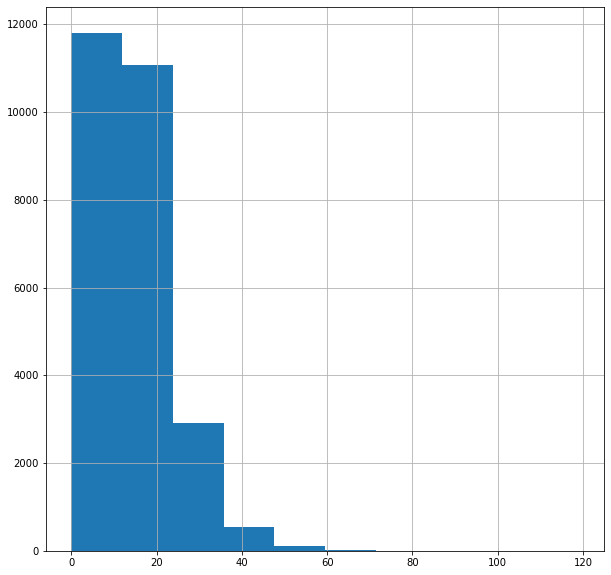

In [5]:
data['num_orders'].hist(figsize=(10,10));

Отсортируем данные по возрастанию

In [6]:
data.sort_index(inplace=True)

Ресемплируем данные по 1ч

In [7]:
data = data.resample('1H').sum()

In [8]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Построим скользящее среднее с окном = 5

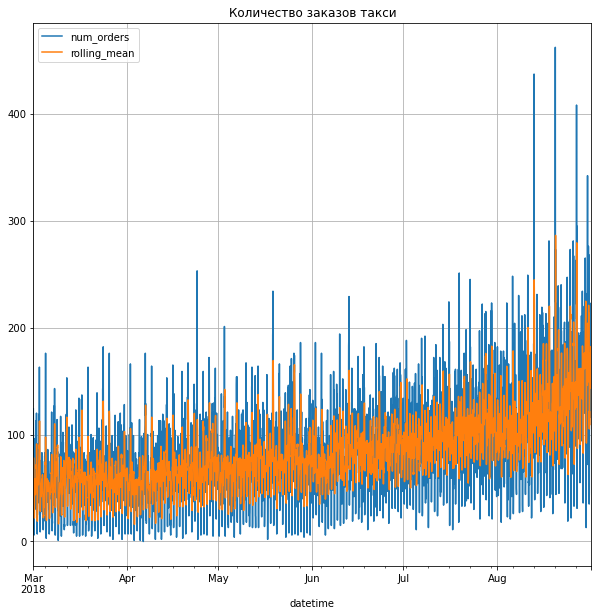

In [9]:
data['rolling_mean'] = data['num_orders'].rolling(5).mean()
ax = data.plot(figsize=(10,10));
ax.set_title('Количество заказов такси');
ax.grid(True);

Посмотрим на сезонное и трендовые составляющие ДФ

In [10]:
decomposed_data = seasonal_decompose(data['num_orders'])

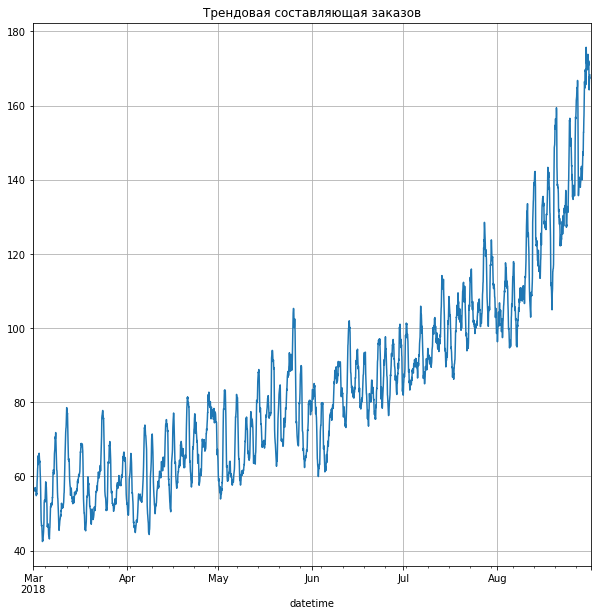

In [11]:
ax = decomposed_data.trend.plot(figsize=(10,10));
ax.set_title('Трендовая составляющая заказов');
ax.grid(True);

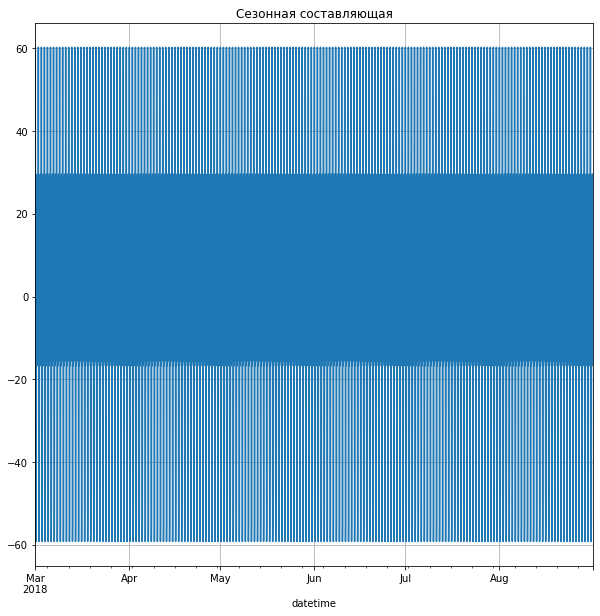

In [12]:
ax = decomposed_data.seasonal.plot(figsize=(10,10));
ax.set_title('Сезонная составляющая');
ax.grid(True);

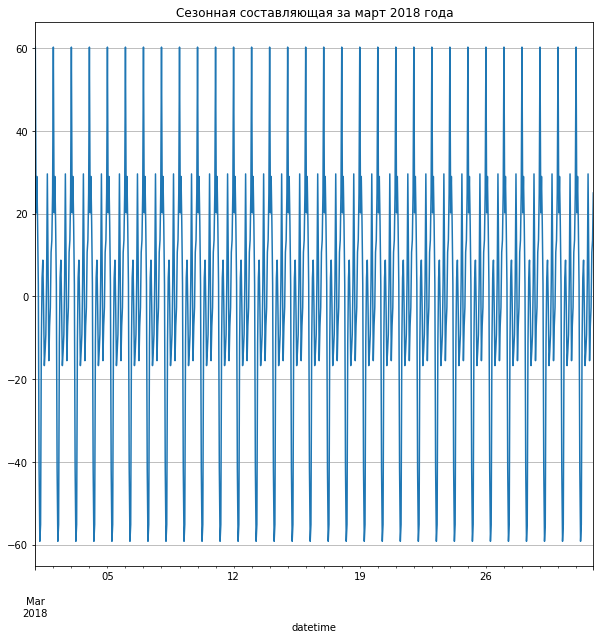

In [13]:
ax = decomposed_data.seasonal['2018-03-01' : '2018-03-31'].plot(figsize=(10,10))
ax.grid(True);
ax.set_title('Сезонная составляющая за март 2018 года');

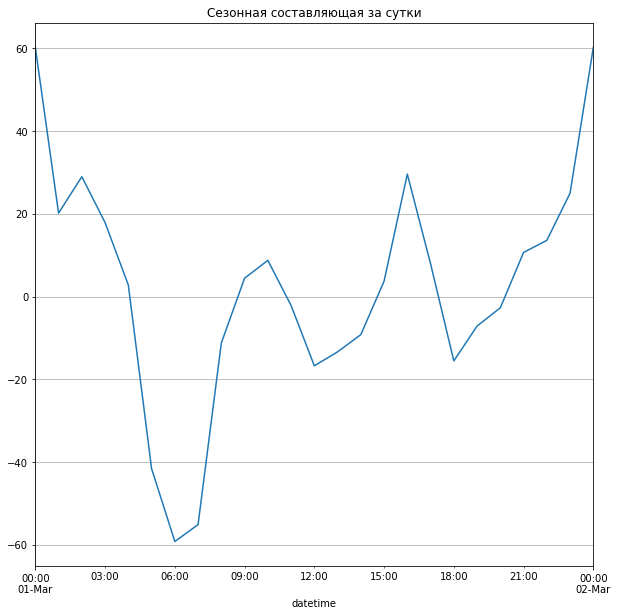

In [14]:
ax = decomposed_data.seasonal['2018-03-01 00:00:00' : '2018-03-02 00:00:00'].plot(figsize=(10,10));
ax.set_title('Сезонная составляющая за сутки');
ax.grid(True);

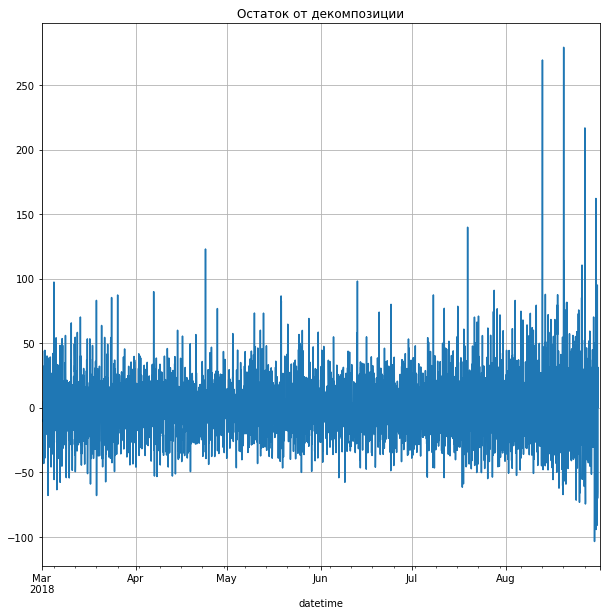

In [15]:
ax = decomposed_data.resid.plot(figsize=(10,10));
ax.set_title('Остаток от декомпозиции');
ax.grid(True)

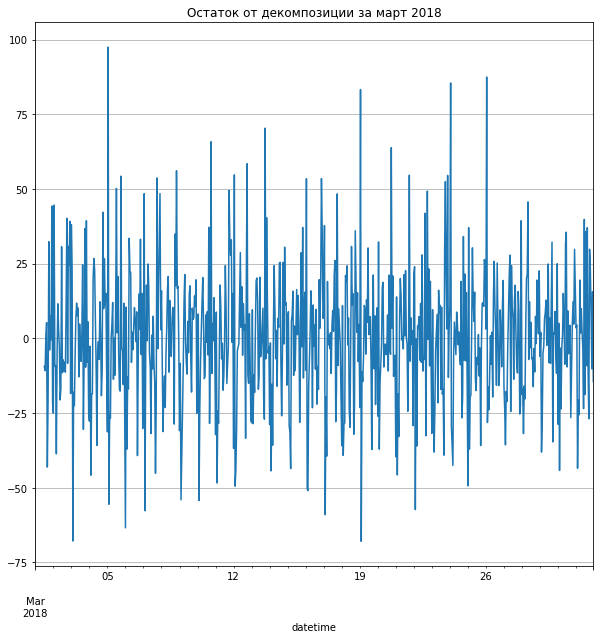

In [16]:
ax = decomposed_data.resid['2018-03-01' : '2018-03-31'].plot(figsize=(10,10));
ax.set_title('Остаток от декомпозиции за март 2018');
ax.grid(True)

Как видно из графиков, тренд идет на увеличение поездок к концу года, а сезонных составляющиие различимы на суточном графике: там в 6 утра минимальное количество заказов, а в 10 и в 16 всплески активности. К вечеру количество заказов растет.

Для обучения модели создадим 10 столбцов с лаг-данными

In [18]:
data.head()

,num_orders,rolling_mean
datetime,,
2018-03-01 00:00:00,124,NaN
2018-03-01 01:00:00,85,NaN
2018-03-01 02:00:00,71,NaN
2018-03-01 03:00:00,66,NaN
2018-03-01 04:00:00,43,77.8


In [19]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    data['hour'] = data.index.hour
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [20]:
data_f = make_features(data, 150, 20)

C:\Users\FunnyFunFruit\AppData\Local\Temp\ipykernel_34792\1477808880.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\FunnyFunFruit\AppData\Local\Temp\ipykernel_34792\1477808880.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
C:\Users\FunnyFunFruit\AppData\Local\Temp\ipykernel_34792\1477808880.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.i

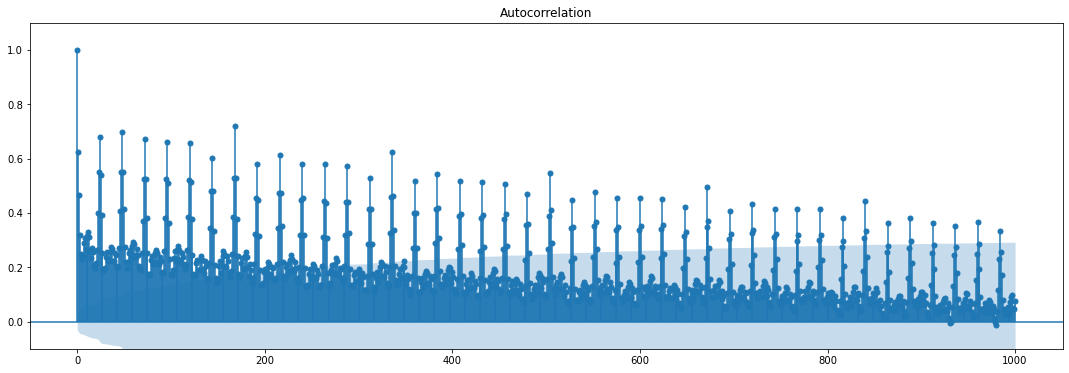

In [21]:
# Код ревьюера
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt 

fig = tsaplots.plot_acf(data['num_orders'],lags= 1000)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 



Разделим выборку на обучающую и тестовую

In [22]:
train, test = train_test_split(data_f, shuffle=False, test_size=0.1)

In [23]:
train_features = train.drop('num_orders', axis=1)
train_target = train['num_orders']

test_features = test.drop('num_orders', axis=1)
test_target = test['num_orders']

## Обучение

С помощью make_scorer создадим скорер RMSE для использования в GridSearchCV

In [24]:
def rmse(true, prediction):
    rmse = mean_squared_error(true, prediction, squared=False)
    return rmse

In [25]:
scorer_rmse = make_scorer(rmse, greater_is_better=False)

С помощью GridSearchCV подберем гиперпараметры для модели LGBMRegressor

In [26]:
%%time
model_1 = LGBMRegressor()

CPU times: total: 0 ns
Wall time: 0 ns


In [27]:
parameters_1 = {'num_leaves' : range(10, 50, 10),
                'max_depth' : range(1, 11, 2),
                'learning_rate' : [0.1, 0.2, 0.3, 0.4, 0.5],
                'n_estimators' : range(50, 200, 20)}

In [28]:
%%time
tscv = TimeSeriesSplit(n_splits=10)
grid_1 = RandomizedSearchCV(estimator=model_1, param_distributions=parameters_1, cv=tscv, n_iter=50, n_jobs=-1, 
                            scoring=scorer_rmse)
grid_1.fit(train_features, train_target)

CPU times: total: 2.94 s
Wall time: 45.9 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
                   estimator=LGBMRegressor(), n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3, 0.4,
                                                          0.5],
                                        'max_depth': range(1, 11, 2),
                                        'n_estimators': range(50, 200, 20),
                                        'num_leaves': range(10, 50, 10)},
                   scoring=make_scorer(rmse, greater_is_better=False))

In [29]:
grid_1.best_score_

-22.77899170183216

In [30]:
grid_1.best_params_

{'num_leaves': 30, 'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.1}

Лучшая метрика составила 22.78, а лучшие гиперпараметры указаны строкой выше

In [31]:
train_features_reg = train_features.fillna('1111')
test_features_reg = test_features.fillna('1111')

In [32]:
parameters_2 = {'n_estimators' : range(50, 250, 50),
                'max_depth' : range(1, 50, 5),
                'min_samples_split' : range(2, 40, 8), 
                'min_samples_leaf' : range(1, 40, 8),
                'criterion' : ['squared_error', 'absolute_error', 'poisson']}

In [33]:
#model_2 = RandomForestRegressor()
#grid_2 = RandomizedSearchCV(estimator=model_2, param_distributions=parameters_2, n_jobs=-1, n_iter=50, scoring=rmse, cv=tscv)

In [34]:
#%%time
#grid_2.fit(train_features, train_target)

In [35]:
model_3 = LinearRegression()
cross_val_score(model_3, train_features_reg, train_target, scoring=scorer_rmse, cv=10).mean()

-37.47501505290848

Были рассмотрены модели линейной регрессии и регрессионная модель случайного леса. В случае линейной регрессии метрика составила 37.48, а в случае случайного леса время подбора параметров и обучения оставляет желать лучшего, в связи с чем было решено от них отказаться

## Тестирование

Протестируем модель на тестовой выборке

In [36]:
%%time
model_1_test = grid_1.best_estimator_
model_1_test.fit(train_features, train_target)
prediction_1_test = model_1_test.predict(test_features)
print('RMSE:', mean_squared_error(test_target, prediction_1_test, squared=False))

RMSE: 38.825878242307745
CPU times: total: 1.72 s
Wall time: 118 ms


Метрика RMSE модели LGMBRegressor составила порядка 39, что является приемлимым результатом. При этом скорость обучения и предсказания данной модели составляет менее минуты, что несомненно является плюсом для данной модели